In [1]:
import mne
mne.set_log_level('WARNING')

import scipy.io
import numpy as np
mat = scipy.io.loadmat('./A03.mat')

In [3]:
# Data point zero for the eight channels.  Should be in V.
signal = mat['data'][0][0][1] * pow(10,6)

print(signal.shape)

(347704, 8)


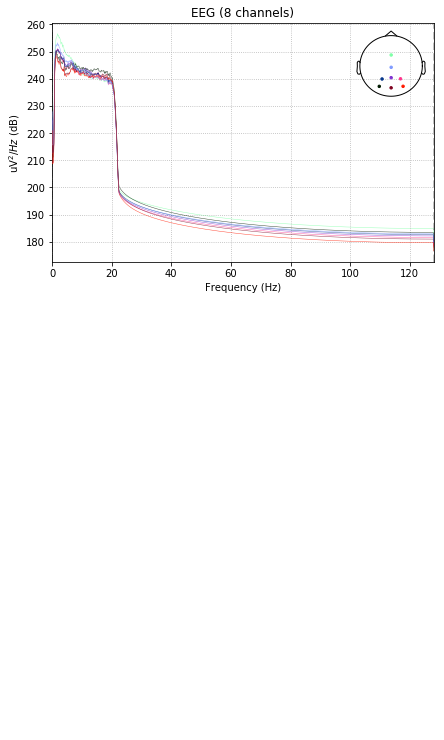

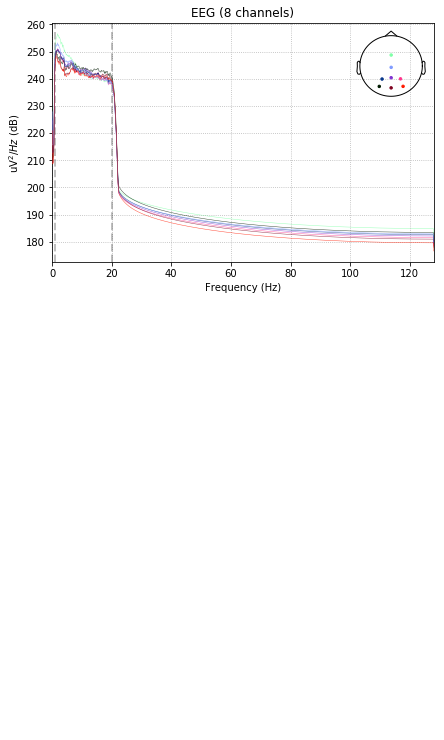

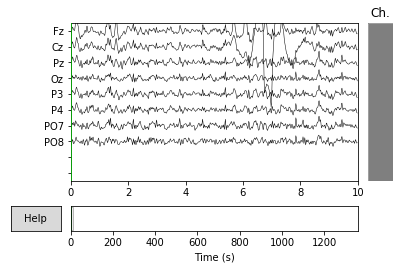

In [42]:
ch_names=[ 'Fz'  ,  'Cz',    'Pz' ,   'Oz'  ,  'P3'  ,  'P4'   , 'PO7'   , 'PO8']
ch_types= ['eeg'] * signal.shape[1]

info = mne.create_info(ch_names, 256, ch_types=ch_types, montage="standard_1020")

eeg_mne = mne.io.array.RawArray(signal.T, info)

eeg_mne.plot_psd()

eeg_mne.filter(1,20)

eeg_mne.plot_psd()

plots = eeg_mne.plot(n_channels=10, block=True, scalings="auto")

Epochs x channels x time
(700, 8, 257)


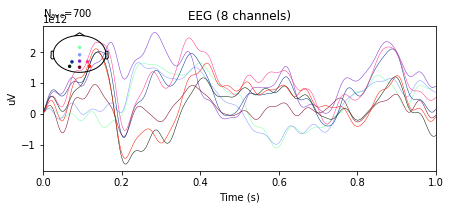

(3500, 8, 257)


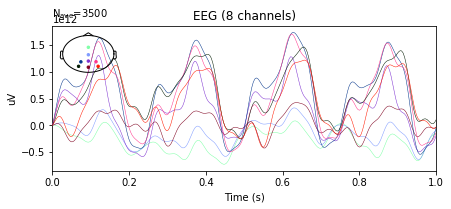

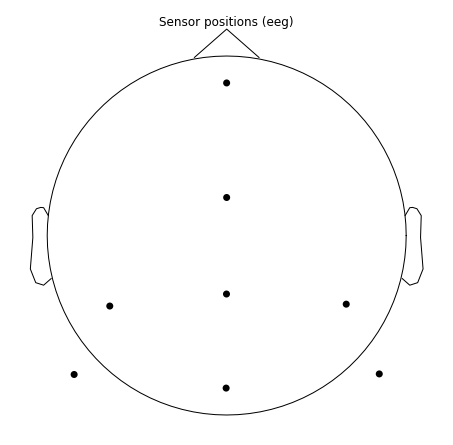

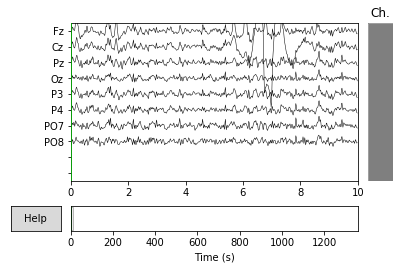

In [49]:
# Now get the trial information

ch_names_events = ch_names + ['t_type']
ch_types_events = ch_types + ['misc']

# Hits and nohits
t_type = mat['data'][0][0][2]

signal_events = np.concatenate([signal, t_type],1)

info_events = mne.create_info(ch_names_events,256, ch_types_events)

eeg_events = mne.io.RawArray(signal_events.T, info_events)

event_times = mne.find_events(eeg_events, stim_channel='t_type')

event_id = { 'second':2 }

tmin = 0
tmax = 1

epochs = mne.Epochs(eeg_mne, event_times, event_id, tmin, tmax)

print ('Epochs x channels x time')
print (epochs.get_data().shape)

evoked = epochs.average()

evoked.plot(time_unit='s', spatial_colors=True)


epochsn = mne.Epochs(eeg_mne, event_times, {'first':1}, tmin, tmax)

print (epochsn.get_data().shape)

evokedn = epochsn.average()

evokedn.plot(time_unit='s', spatial_colors=True)


montage = mne.channels.read_montage('standard_1020')

eeg_mne.set_montage(montage)

eeg_mne.plot_sensors()

plots = eeg_mne.plot(n_channels=10, scalings='auto',block=True)

In [55]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm

In [57]:
# Create classification pipeline
clf = make_pipeline(mne.preprocessing.Xdawn(n_components=3),
                    mne.decoding.Vectorizer(),
                    MinMaxScaler(),
                    #LogisticRegression(penalty='l1'))
                    svm.SVC())

event_id = { 'first':1, 'second':2 }

epochs = mne.Epochs(eeg_mne, event_times, event_id, tmin, tmax, proj=False,
                baseline=None, preload=True,
                verbose=False)

labels = epochs.events[:, -1]

In [58]:
# Cross validator
cv = StratifiedKFold(y=labels, n_folds=10, shuffle=True, random_state=42)

# Do cross-validation
preds = np.empty(len(labels))
for train, test in cv:
    cf=clf.fit(epochs[train], labels[train])
    preds[test] = clf.predict(epochs[test])

In [59]:
# Classification report
target_names = ['nohit', 'hit']

report = classification_report(labels, preds, target_names=target_names)
print(report)

cm = confusion_matrix(labels, preds)
print (cm)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

             precision    recall  f1-score   support

      nohit       0.83      1.00      0.91      3500
        hit       0.00      0.00      0.00       700

avg / total       0.69      0.83      0.76      4200

[[3500    0]
 [ 700    0]]


/usr/local/anaconda3/envs/mne/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

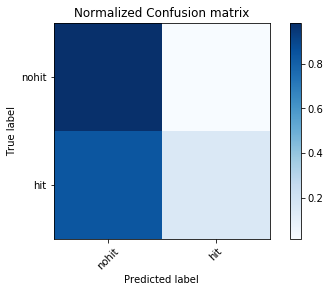

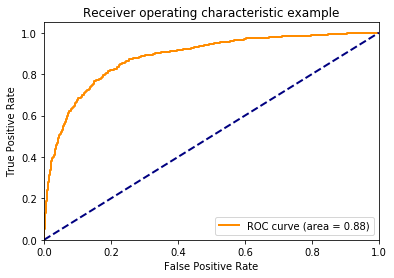

In [25]:
# Plot confusion matrix
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
mne.viz.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

np.where( labels == 3 )

y_score = cf.decision_function(epochs)
fpr, tpr, _ = roc_curve(labels, y_score,pos_label=2)
roc_auc = auc(fpr,tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [26]:
from sklearn.decomposition import PCA, FastICA

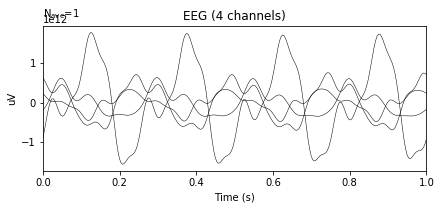

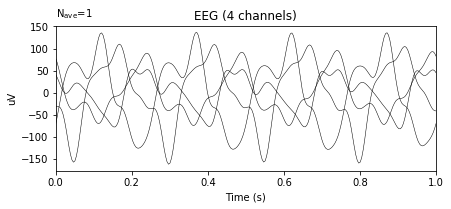

In [28]:
X = epochs.get_data()

pca = mne.decoding.UnsupervisedSpatialFilter(PCA(4), average=False)
pca_data = pca.fit_transform(X)
ev = mne.EvokedArray(np.mean(pca_data, axis=0),
                     mne.create_info(4, epochs.info['sfreq'],
                                     ch_types='eeg'), tmin=tmin)
ev.plot(show=False, window_title="PCA", time_unit='s')


ica = mne.decoding.UnsupervisedSpatialFilter(FastICA(4), average=False)
ica_data = ica.fit_transform(X)
ev1 = mne.EvokedArray(np.mean(ica_data, axis=0),
                      mne.create_info(4, epochs.info['sfreq'],
                                      ch_types='eeg'), tmin=tmin)
ev1.plot(show=False, window_title='ICA', time_unit='s')

plt.show()